In [21]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from joblib import Parallel, delayed
from helper.system import Hamiltonian

In [22]:
# ── System parameters (g halved, two active cavities) ───────────────────
Ej = 30.19
Ec = 0.1
omega_c1 = 5.226
omega_c2 = 8.135
phi_ex = 0.2
bare_dim = [10, 6, 6]
trunc_dim = [3, 3, 3]   # total dim = 18, both cavities active

g_val = 0.05 * 2 * np.pi   # half the default g = 0.05*2pi

# Build Hamiltonian with reduced g
sc = Hamiltonian(phi_ex, Ej, Ec, bare_dim, trunc_dim, omega_c1, omega_c2)
sc.g = g_val
sc.H, sc.H_control = sc.get_H()
sc.H_dressed, sc.H_control_dressed = sc.dressed_basis()

# Reference energies
dim = sc.original_dim
omega_s = sc.H_dressed[sc.state_index((1,0,0), dim), sc.state_index((1,0,0), dim)].real
E_c1 = sc.H_dressed[sc.state_index((0,0,1), dim), sc.state_index((0,0,1), dim)].real
E_c2 = sc.H_dressed[sc.state_index((0,1,0), dim), sc.state_index((0,1,0), dim)].real

print(f"Dressed SNAIL freq:       {omega_s/(2*np.pi):.4f} GHz")
print(f"Cavity 1 (1 photon):      {E_c1/(2*np.pi):.4f} GHz")
print(f"Cavity 2 (1 photon):      {E_c2/(2*np.pi):.4f} GHz")
print(f"Cavity diff (c1 - c2):    {(E_c1 - E_c2)/(2*np.pi):.4f} GHz")

Dressed SNAIL freq:       6.1536 GHz
Cavity 1 (1 photon):      8.1392 GHz
Cavity 2 (1 photon):      5.2148 GHz
Cavity diff (c1 - c2):    2.9243 GHz


In [23]:
# ── Helper: full quasi-energy spectrum & gradient ────────────────────────
from scipy.integrate import solve_ivp

def quasi_energy_full(sc_obj, A, omega):
    """Return ALL sorted quasi-energies using dense numpy Floquet solver."""
    H0 = np.array(sc_obj.H_dressed)
    Hc = np.array(sc_obj.H_control_dressed)
    T = 2 * np.pi / omega
    n = H0.shape[0]

    def propagator_ode(t, U_flat):
        U = U_flat.reshape(n, n)
        H = H0 + A * np.cos(omega * t) * Hc
        return (-1j * H @ U).flatten()

    U0 = np.eye(n, dtype=complex).flatten()
    sol = solve_ivp(propagator_ode, [0, T], U0, method='DOP853',
                    rtol=1e-10, atol=1e-12, max_step=T/50)
    U_T = sol.y[:, -1].reshape(n, n)

    evals, evecs = np.linalg.eig(U_T)
    e_quasi = -np.angle(evals) * omega / (2 * np.pi)
    evals_s, _ = sc_obj.sort_eigenpairs(e_quasi, evecs)
    return evals_s - evals_s[0]


# State indices with trunc_dim = [3, 2, 3]:
#   (0,0,0) -> idx 0  ground
#   (0,0,1) -> idx 1  one photon in cavity 1
#   (0,1,0) -> idx 3  one photon in cavity 2
idx_c1 = sc.state_index((0, 0, 1), dim)
idx_c2 = sc.state_index((0, 1, 0), dim)
print(f"Index for cavity 1 photon: {idx_c1}")
print(f"Index for cavity 2 photon: {idx_c2}")


def compute_derivatives(omegad, A):
    """Compute |d(omega_c1)/dPhi|, |d(omega_c2)/dPhi|, |d(omega_c1-omega_c2)/dPhi|."""
    delta = 1e-6

    def get_eq(p):
        sc_t = Hamiltonian(p, Ej, Ec, bare_dim, trunc_dim, omega_c1, omega_c2)
        sc_t.g = g_val
        sc_t.H, sc_t.H_control = sc_t.get_H()
        sc_t.H_dressed, sc_t.H_control_dressed = sc_t.dressed_basis()
        return quasi_energy_full(sc_t, A, omegad)

    Ep = get_eq(phi_ex + delta)
    Em = get_eq(phi_ex - delta)
    grad = (Ep - Em) / (2 * delta)

    d_c1 = np.abs(grad[idx_c1]) / (2 * np.pi)                    # |d(omega_c1)/dPhi|
    d_c2 = np.abs(grad[idx_c2]) / (2 * np.pi)                    # |d(omega_c2)/dPhi|
    d_diff = np.abs(grad[idx_c1] - grad[idx_c2]) / (2 * np.pi)   # |d(omega_c1 - omega_c2)/dPhi|
    return d_c1, d_c2, d_diff

Index for cavity 1 photon: 1
Index for cavity 2 photon: 6


In [24]:
# ── Sweep: fixed amplitude, vary drive frequency ────────────────────────
A = 10e-3 * 2 * np.pi
N_pts = 100

# Log-spaced positive detuning only (GHz)
det_min, det_max = 0.02, 0.05   # GHz
detunings_ghz = np.logspace(np.log10(det_min), np.log10(det_max), N_pts)
omega_ds = omega_s + detunings_ghz * 2 * np.pi

print(f"Running {N_pts} detuning points at A/(2pi) = {A/(2*np.pi)*1e3:.2f} MHz ...")

def compute_derivatives_with_progress(i, omegad, A):
    result = compute_derivatives(omegad, A)
    print(f"  [{i+1}/{N_pts}] detuning = {(omegad - omega_s)/(2*np.pi)*1e3:.2f} MHz done")
    return result

results = Parallel(n_jobs=-1)(
    delayed(compute_derivatives_with_progress)(i, wd, A) for i, wd in enumerate(omega_ds)
)

d_c1_arr = np.array([r[0] for r in results])
d_c2_arr = np.array([r[1] for r in results])
d_diff_arr = np.array([r[2] for r in results])


Running 100 detuning points at A/(2pi) = 10.00 MHz ...
  [45/100] detuning = 30.05 MHz done
  [60/100] detuning = 34.53 MHz done
  [52/100] detuning = 32.06 MHz done
  [17/100] detuning = 23.19 MHz done
  [14/100] detuning = 22.56 MHz done
  [64/100] detuning = 35.83 MHz done
  [11/100] detuning = 21.94 MHz done
  [29/100] detuning = 25.92 MHz done
  [22/100] detuning = 24.29 MHz done
  [59/100] detuning = 34.21 MHz done
  [1/100] detuning = 20.00 MHz done
  [63/100] detuning = 35.50 MHz done
  [51/100] detuning = 31.77 MHz done
  [56/100] detuning = 33.27 MHz done
  [35/100] detuning = 27.40 MHz done
  [53/100] detuning = 32.36 MHz done
  [32/100] detuning = 26.65 MHz done
  [19/100] detuning = 23.63 MHz done
  [55/100] detuning = 32.97 MHz done
  [25/100] detuning = 24.97 MHz done
  [24/100] detuning = 24.74 MHz done
  [50/100] detuning = 31.48 MHz done
  [62/100] detuning = 35.17 MHz done
  [61/100] detuning = 34.85 MHz done
  [48/100] detuning = 30.90 MHz done
  [27/100] detuning =

In [25]:

# Save data
import pickle
sweep_data = {
    'A': A,
    'detunings_ghz': detunings_ghz,
    'omega_ds': omega_ds,
    'omega_s': omega_s,
    'd_c1_arr': d_c1_arr,
    'd_c2_arr': d_c2_arr,
    'd_diff_arr': d_diff_arr,
}
with open('dual_rail_sweep_data.pkl', 'wb') as f:
    pickle.dump(sweep_data, f)
print("Data saved to dual_rail_sweep_data.pkl")


Data saved to dual_rail_sweep_data.pkl


Loaded 100 data points, A/(2pi) = 10.00 MHz


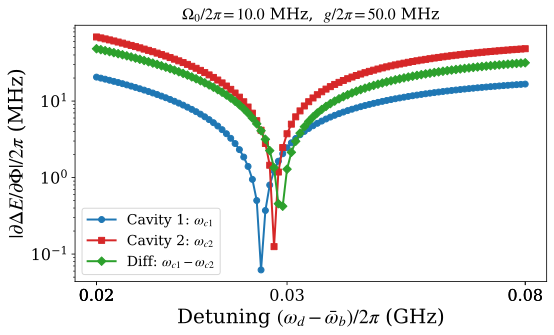

In [26]:
# ── Load data and plot ───────────────────────────────────────────────────
import pickle
with open('dual_rail_sweep_data.pkl', 'rb') as f:
    sweep_data = pickle.load(f)
A = sweep_data['A']
detunings_ghz = sweep_data['detunings_ghz']
omega_ds = sweep_data['omega_ds']
omega_s = sweep_data['omega_s']
d_c1_arr = sweep_data['d_c1_arr']
d_c2_arr = sweep_data['d_c2_arr']
d_diff_arr = sweep_data['d_diff_arr']
N_pts = len(detunings_ghz)
print(f"Loaded {N_pts} data points, A/(2pi) = {A/(2*np.pi)*1e3:.2f} MHz")

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times', 'DejaVu Serif'],
    'font.size': 16,
    'axes.titlesize': 16,
    'axes.labelsize': 20,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
    'figure.titlesize': 16,
    'mathtext.fontset': 'stix'
})

fig, ax = plt.subplots(figsize=(8, 5))

# Use integer indices for log-like x-axis
x_idx = np.arange(N_pts)

ax.plot(x_idx, d_c1_arr * 1e3, 'o-', linewidth=2, label=r'Cavity 1: $\omega_{c1}$', color='tab:blue')
ax.plot(x_idx, d_c2_arr * 1e3, 's-', linewidth=2, label=r'Cavity 2: $\omega_{c2}$', color='tab:red')
ax.plot(x_idx, d_diff_arr * 1e3, 'D-', linewidth=2, label=r'Diff: $\omega_{c1} - \omega_{c2}$', color='tab:green')

# Custom x-tick labels: pick a few clean values
tick_values = [0.007, 0.01, 0.02, 0.03, 0.05, 0.08]
tick_pos = [np.argmin(np.abs(detunings_ghz - v)) for v in tick_values]
tick_lbl = [f'{v}' for v in tick_values]
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_lbl)

ax.set_xlabel(r'Detuning $(\omega_d - \bar{\omega}_b)/2\pi$ (GHz)')
ax.set_ylabel(r'$|\partial \Delta E / \partial \Phi|/2\pi$ (MHz)')
ax.set_yscale('log')
ax.set_title(rf'$\Omega_0/2\pi = {A/(2*np.pi)*1e3:.1f}$ MHz,  $g/2\pi = {g_val/(2*np.pi)*1e3:.1f}$ MHz')
ax.legend()

plt.tight_layout()
plt.savefig('dual_rail.pdf', bbox_inches='tight')
plt.show()